In [690]:
import requests
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time

In [691]:
import requests
import pandas as pd

def get_historical_data():
    # Prix et volume historiques
    url_market_chart = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': 'max',
        'interval': 'daily'
    }
    response = requests.get(url_market_chart, params=params)
    market_data = response.json()
    
    # Convertir les données en DataFrame
    df = pd.DataFrame(market_data['prices'], columns=['timestamp', 'price'])
    
    # Convertir le timestamp en datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Définir le timestamp comme index
    df.set_index('timestamp', inplace=True)
    
    return df

# Utilisation de la fonction
btc_data = get_historical_data()

# Afficher les premières lignes du DataFrame
btc_data

,price
timestamp,
2013-04-28 00:00:00,135.300000
2013-04-29 00:00:00,141.960000
2013-04-30 00:00:00,135.300000
2013-05-01 00:00:00,117.000000
2013-05-02 00:00:00,103.430000
...,...
2023-10-14 00:00:00,26841.136221
2023-10-15 00:00:00,26863.183569
2023-10-16 00:00:00,27150.297001


In [692]:
def get_market_cap_data():
    # Récupérer la capitalisation boursière historique
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': 'max',
        'interval': 'daily'
    }
    response = requests.get(url, params=params)
    market_data = response.json()
    
    # Convertir les données en DataFrame
    df_market_cap = pd.DataFrame(market_data['market_caps'], columns=['timestamp', 'market_cap'])
    
    # Convertir le timestamp en datetime et le définir comme index
    df_market_cap['timestamp'] = pd.to_datetime(df_market_cap['timestamp'], unit='ms')
    df_market_cap.set_index('timestamp', inplace=True)
    
    return df_market_cap

# Utilisation de la fonction
market_cap_data = get_market_cap_data()

# Fusionner les données de capitalisation boursière avec btc_data
btc_data = btc_data.merge(market_cap_data, left_index=True, right_index=True, how='left')

# Afficher les premières lignes du DataFrame mis à jour
btc_data

,price,market_cap
timestamp,,
2013-04-28 00:00:00,135.300000,1.500518e+09
2013-04-29 00:00:00,141.960000,1.575032e+09
2013-04-30 00:00:00,135.300000,1.501657e+09
2013-05-01 00:00:00,117.000000,1.298952e+09
2013-05-02 00:00:00,103.430000,1.148668e+09
...,...,...
2023-10-14 00:00:00,26841.136221,5.236556e+11
2023-10-15 00:00:00,26863.183569,5.239792e+11
2023-10-16 00:00:00,27150.297001,5.296435e+11


In [693]:
# Convertir l'index en dates et supprimer l'heure
btc_data.index = pd.to_datetime(btc_data.index).date

# Supprimer les doublons basés sur la date
btc_data = btc_data[~btc_data.index.duplicated(keep='first')]

In [694]:
btc_data

,price,market_cap
2013-04-28,135.300000,1.500518e+09
2013-04-29,141.960000,1.575032e+09
2013-04-30,135.300000,1.501657e+09
2013-05-01,117.000000,1.298952e+09
2013-05-02,103.430000,1.148668e+09
...,...,...
2023-10-13,26729.137206,5.216077e+11
2023-10-14,26841.136221,5.236556e+11
2023-10-15,26863.183569,5.239792e+11
2023-10-16,27150.297001,5.296435e+11


In [695]:
import time

# Votre clé API
api_key = input("Please enter your CryptoCompare API key: ")

# Convertit la date '28/04/2013' en timestamp UNIX
start_date = '12/10/2010 00:00:00'
start_timestamp = int(time.mktime(time.strptime(start_date, '%d/%m/%Y %H:%M:%S')))

# Timestamp pour aujourd'hui
end_timestamp = int(time.time())

# Limite de points de données par requête
limit = 2000

# Calcule le nombre total de jours et de requêtes nécessaires
total_days = (end_timestamp - start_timestamp) // (24 * 60 * 60)
total_requests = -(-total_days // limit)  # Utilise la division entière arrondie vers le haut

# Initialise un DataFrame vide
btc_data_full = pd.DataFrame()

# Fait plusieurs requêtes pour couvrir toute la période
for i in range(total_requests):
    # Ajuste le paramètre toTs pour chaque requête
    toTs = end_timestamp - i * limit * 24 * 60 * 60
    
    # Construit l'URL de l'API
    url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit={limit}&toTs={toTs}&api_key={api_key}'
    
    # Fait la requête API
    response = requests.get(url)
    data = response.json()
    
    # Crée un DataFrame avec les données obtenues
    new_data = pd.DataFrame(data['Data']['Data'])
    new_data['time'] = pd.to_datetime(new_data['time'], unit='s')
    new_data.set_index('time', inplace=True)
    
    # Concaténe les nouveaux données avec les données existantes
    btc_data_full = pd.concat([new_data, btc_data_full])

# Trie le DataFrame combiné par index (date)
btc_data_full.sort_index(inplace=True)

# Filtre les données pour n'inclure que celles depuis le 28/04/2013
btc_data_full = btc_data_full[btc_data_full.index >= start_date]

# Affiche le DataFrame
btc_data_full

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2010-12-10,0.2040,0.1825,0.2000,1684.25,3.281700e+02,0.2040,direct,
2010-12-11,0.2280,0.1907,0.2040,5788.69,1.267200e+03,0.2280,direct,
2010-12-12,0.2280,0.2068,0.2280,1963.56,4.188000e+02,0.2200,direct,
2010-12-13,0.2300,0.2100,0.2200,6415.59,1.425920e+03,0.2299,direct,
2010-12-14,0.2468,0.2100,0.2299,10388.10,2.403830e+03,0.2467,direct,
...,...,...,...,...,...,...,...,...
2023-10-13,27110.9100,26674.9700,26756.2300,18507.04,4.967794e+08,26862.9000,direct,
2023-10-14,26982.7800,26810.0200,26862.9000,5865.21,1.576854e+08,26854.5200,direct,
2023-10-15,27297.2600,26813.0600,26854.5200,10978.68,2.971100e+08,27177.4100,direct,


In [696]:
btc_data_full.drop(['conversionSymbol', 'conversionType'], axis=1, inplace=True)

In [697]:
duplicates = btc_data_full.index.duplicated(keep=False)
print(btc_data_full[duplicates])

               high      low     open  volumefrom      volumeto    close
time                                                                    
2012-11-03    10.65    10.40    10.47    16732.94  1.763451e+05    10.64
2012-11-03    10.65    10.40    10.47    16732.94  1.763451e+05    10.64
2018-04-26  9315.13  8669.38  8873.57   111690.32  9.974279e+08  9282.12
2018-04-26  9315.13  8669.38  8873.57   111690.32  9.974279e+08  9282.12


In [698]:
btc_data_full = btc_data_full[~btc_data_full.index.duplicated(keep='first')]

In [699]:
btc_data

,price,market_cap
2013-04-28,135.300000,1.500518e+09
2013-04-29,141.960000,1.575032e+09
2013-04-30,135.300000,1.501657e+09
2013-05-01,117.000000,1.298952e+09
2013-05-02,103.430000,1.148668e+09
...,...,...
2023-10-13,26729.137206,5.216077e+11
2023-10-14,26841.136221,5.236556e+11
2023-10-15,26863.183569,5.239792e+11
2023-10-16,27150.297001,5.296435e+11


In [700]:
btc_data_full['market_cap'] = btc_data['market_cap']

In [701]:
btc_data = btc_data_full.copy()

In [702]:
pd.options.mode.chained_assignment = None  # default='warn'

btc_data["progression daily"] = 0.0
btc_data["progression tomorrow"] = 0.0

# Calcul de la progression quotidienne
btc_data.loc[:, "progression daily"] = btc_data['open'].pct_change()

# Calcul de la progression du lendemain
btc_data["progression tomorrow"] = btc_data["close"].values / btc_data["open"].values - 1

In [703]:
btc_data

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow
time,,,,,,,,,
2010-12-10,0.2040,0.1825,0.2000,1684.25,3.281700e+02,0.2040,NaN,NaN,0.020000
2010-12-11,0.2280,0.1907,0.2040,5788.69,1.267200e+03,0.2280,NaN,0.020000,0.117647
2010-12-12,0.2280,0.2068,0.2280,1963.56,4.188000e+02,0.2200,NaN,0.117647,-0.035088
2010-12-13,0.2300,0.2100,0.2200,6415.59,1.425920e+03,0.2299,NaN,-0.035088,0.045000
2010-12-14,0.2468,0.2100,0.2299,10388.10,2.403830e+03,0.2467,NaN,0.045000,0.073075
...,...,...,...,...,...,...,...,...,...
2023-10-13,27110.9100,26674.9700,26756.2300,18507.04,4.967794e+08,26862.9000,5.216077e+11,-0.004279,0.003987
2023-10-14,26982.7800,26810.0200,26862.9000,5865.21,1.576854e+08,26854.5200,5.236556e+11,0.003987,-0.000312
2023-10-15,27297.2600,26813.0600,26854.5200,10978.68,2.971100e+08,27177.4100,5.239792e+11,-0.000312,0.012024


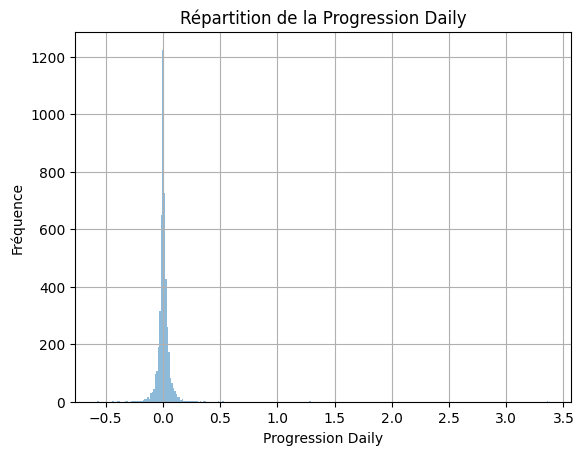

In [704]:
# Affichage de l'histogramme de la progression quotidienne
plt.hist(btc_data['progression daily'].dropna(), bins=300, alpha=0.5)
plt.title('Répartition de la Progression Daily')
plt.xlabel('Progression Daily')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [705]:
print(btc_data['progression daily'].describe())

count    4694.000000
mean        0.004322
std         0.072789
min        -0.572057
25%        -0.013609
50%         0.001503
75%         0.019603
max         3.368390
Name: progression daily, dtype: float64


In [706]:
btc_data.loc[btc_data['volumefrom']==0]

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow
time,,,,,,,,,
2011-06-20,17.51,17.51,17.51,0.0,0.0,17.51,NaN,0.036708,0.0
2011-06-21,17.51,17.51,17.51,0.0,0.0,17.51,NaN,0.000000,0.0
2011-06-22,17.51,17.51,17.51,0.0,0.0,17.51,NaN,0.000000,0.0
2011-06-23,17.51,17.51,17.51,0.0,0.0,17.51,NaN,0.000000,0.0
2011-06-24,17.51,17.51,17.51,0.0,0.0,17.51,NaN,0.000000,0.0
2011-06-25,17.51,17.51,17.51,0.0,0.0,17.51,NaN,0.000000,0.0


In [707]:
btc_data['2011-06-15':'2011-06-30']

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow
time,,,,,,,,,
2011-06-15,20.00,19.02,19.28,27711.90,545336.14,19.49,NaN,-0.028226,0.010892
2011-06-16,19.89,17.00,19.49,49202.14,927743.42,17.00,NaN,0.010892,-0.127758
2011-06-17,18.34,13.00,17.00,108623.77,1684353.23,15.68,NaN,-0.127758,-0.077647
2011-06-18,16.95,15.05,15.68,35536.55,569949.34,16.89,NaN,-0.077647,0.077168
2011-06-19,18.88,16.85,16.89,30176.74,536267.38,17.51,NaN,0.077168,0.036708
2011-06-20,17.51,17.51,17.51,0.00,0.00,17.51,NaN,0.036708,0.000000
2011-06-21,17.51,17.51,17.51,0.00,0.00,17.51,NaN,0.000000,0.000000
2011-06-22,17.51,17.51,17.51,0.00,0.00,17.51,NaN,0.000000,0.000000
2011-06-23,17.51,17.51,17.51,0.00,0.00,17.51,NaN,0.000000,0.000000


In [708]:
# Calculez la médiane pour chaque colonne du 15 au 30 juin
median_values = btc_data['2011-06-15':'2011-06-30'].median()

# Affectez la médiane à chaque ligne de la période du 20 au 25 juin, colonne par colonne
for column in btc_data.columns:
    btc_data.loc['2011-06-20':'2011-06-25', column] = median_values[column]

In [709]:
btc_data['2011-06-15':'2011-06-30']

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow
time,,,,,,,,,
2011-06-15,20.00,19.020,19.28,27711.90,545336.14,19.490,NaN,-0.028226,0.010892
2011-06-16,19.89,17.000,19.49,49202.14,927743.42,17.000,NaN,0.010892,-0.127758
2011-06-17,18.34,13.000,17.00,108623.77,1684353.23,15.680,NaN,-0.127758,-0.077647
2011-06-18,16.95,15.050,15.68,35536.55,569949.34,16.890,NaN,-0.077647,0.077168
2011-06-19,18.88,16.850,16.89,30176.74,536267.38,17.510,NaN,0.077168,0.036708
2011-06-20,17.51,16.925,17.51,22720.76,384167.70,17.255,NaN,0.000000,0.000000
2011-06-21,17.51,16.925,17.51,22720.76,384167.70,17.255,NaN,0.000000,0.000000
2011-06-22,17.51,16.925,17.51,22720.76,384167.70,17.255,NaN,0.000000,0.000000
2011-06-23,17.51,16.925,17.51,22720.76,384167.70,17.255,NaN,0.000000,0.000000


In [710]:
missing_values_sum = btc_data.isna().sum()

In [711]:
missing_values_sum

high                      0
low                       0
open                      0
volumefrom                0
volumeto                  0
close                     0
market_cap              873
progression daily         1
progression tomorrow      0
dtype: int64

In [712]:
"""btc_data.loc[btc_data['market_cap'].isna()]"""

"btc_data.loc[btc_data['market_cap'].isna()]"

In [713]:
"""missing_index = btc_data.loc[btc_data['market_cap'].isna()].index[0]

# Obtenir la position de l'index manquant
missing_pos = btc_data.index.get_loc(missing_index)

# Définir les positions de début et de fin pour l'extraction des données
start_pos = max(0, missing_pos - 3)
end_pos = min(len(btc_data), missing_pos + 4)

# Afficher les 3 lignes avant et après la valeur manquante
subset_btc_data = btc_data.iloc[start_pos:end_pos]
subset_btc_data"""

"missing_index = btc_data.loc[btc_data['market_cap'].isna()].index[0]\n\n# Obtenir la position de l'index manquant\nmissing_pos = btc_data.index.get_loc(missing_index)\n\n# Définir les positions de début et de fin pour l'extraction des données\nstart_pos = max(0, missing_pos - 3)\nend_pos = min(len(btc_data), missing_pos + 4)\n\n# Afficher les 3 lignes avant et après la valeur manquante\nsubset_btc_data = btc_data.iloc[start_pos:end_pos]\nsubset_btc_data"

In [714]:
"""# Trouver l'index de la valeur manquante
missing_index = btc_data.loc[btc_data['market_cap'].isna()].index[0]

# Obtenir la position de l'index manquant
missing_pos = btc_data.index.get_loc(missing_index)

# Calculer la moyenne des valeurs de 'market_cap' qui entourent la valeur manquante
mean_value = (btc_data['market_cap'].iloc[missing_pos - 1] + btc_data['market_cap'].iloc[missing_pos + 1]) / 2

# Remplacer la valeur manquante par la moyenne calculée
btc_data['market_cap'].iloc[missing_pos] = mean_value"""

"# Trouver l'index de la valeur manquante\nmissing_index = btc_data.loc[btc_data['market_cap'].isna()].index[0]\n\n# Obtenir la position de l'index manquant\nmissing_pos = btc_data.index.get_loc(missing_index)\n\n# Calculer la moyenne des valeurs de 'market_cap' qui entourent la valeur manquante\nmean_value = (btc_data['market_cap'].iloc[missing_pos - 1] + btc_data['market_cap'].iloc[missing_pos + 1]) / 2\n\n# Remplacer la valeur manquante par la moyenne calculée\nbtc_data['market_cap'].iloc[missing_pos] = mean_value"

In [715]:
# Créer une variable cible binaire : 1 si la progression demain est positive, 0 sinon
btc_data['target'] = np.where(btc_data['progression tomorrow'] > 0, 1, 0)

In [716]:
btc_data['target'].describe()

count    4695.000000
mean        0.525027
std         0.499426
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [717]:
btc_data.to_csv('data/btc_data')

In [718]:
"""import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import time
import random

# Configurer l'objet pytrends
pytrends = TrendReq()

kw_list = ["Bitcoin"]

# Liste des périodes
timeframes = ['2013-04-28 2018-04-27', '2018-04-28 2023-04-27']

temp = []

for timeframe in timeframes:
    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')
    temp.append(pytrends.interest_over_time())
    time.sleep(random.randint(10, 20))  # Ajoute une pause de X secondes entre chaque requête"""

'import pandas as pd\nfrom pytrends.request import TrendReq\nimport matplotlib.pyplot as plt\nimport time\nimport random\n\n# Configurer l\'objet pytrends\npytrends = TrendReq()\n\nkw_list = ["Bitcoin"]\n\n# Liste des périodes\ntimeframes = [\'2013-04-28 2018-04-27\', \'2018-04-28 2023-04-27\']\n\ntemp = []\n\nfor timeframe in timeframes:\n    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo=\'\', gprop=\'\')\n    temp.append(pytrends.interest_over_time())\n    time.sleep(random.randint(10, 20))  # Ajoute une pause de X secondes entre chaque requête'

In [719]:
"""import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as pltdatetime
from datetime import date

current_date = date.today()
formatted_date = current_date.strftime('%Y-%m-%d')
print(formatted_date)

# Configurer l'objet pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# Définir la requête
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2023-04-28 ' + formatted_date, geo='', gprop='')

# Récupérer les données
df = pytrends.interest_over_time()
temp.append(df)

# Concaténer les dataframes
trends = pd.concat(temp, axis=0)

# Afficher les données
print(trends)


# Visualiser les données
plt.plot(df.index, df['Bitcoin'])
plt.title('Interest Over Time')
plt.xlabel('Date')
plt.ylabel('Trend Index')
plt.grid(True)
plt.show()"""

'import pandas as pd\nfrom pytrends.request import TrendReq\nimport matplotlib.pyplot as pltdatetime\nfrom datetime import date\n\ncurrent_date = date.today()\nformatted_date = current_date.strftime(\'%Y-%m-%d\')\nprint(formatted_date)\n\n# Configurer l\'objet pytrends\npytrends = TrendReq(hl=\'en-US\', tz=360)\n\n# Définir la requête\nkw_list = ["Bitcoin"]\npytrends.build_payload(kw_list, cat=0, timeframe=\'2023-04-28 \' + formatted_date, geo=\'\', gprop=\'\')\n\n# Récupérer les données\ndf = pytrends.interest_over_time()\ntemp.append(df)\n\n# Concaténer les dataframes\ntrends = pd.concat(temp, axis=0)\n\n# Afficher les données\nprint(trends)\n\n\n# Visualiser les données\nplt.plot(df.index, df[\'Bitcoin\'])\nplt.title(\'Interest Over Time\')\nplt.xlabel(\'Date\')\nplt.ylabel(\'Trend Index\')\nplt.grid(True)\nplt.show()'

In [720]:
btc_data.columns

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close', 'market_cap',
       'progression daily', 'progression tomorrow', 'target'],
      dtype='object')

In [721]:
#Calcul EMA 26

# Choix du nombre de périodes pour l'EMA. Habituellement, 12, 26 ou 50 sont utilisés.
n = 26
alpha = 2 / (n + 1)

# Calcul de l'EMA
btc_data['ema_26'] = btc_data['open'].ewm(span=n, adjust=False).mean()

#Calcul EMA 12

# Choix du nombre de périodes pour l'EMA. Habituellement, 12, 26 ou 50 sont utilisés.
n = 12
alpha = 2 / (n + 1)

# Calcul de l'EMA
btc_data['ema_12'] = btc_data['open'].ewm(span=n, adjust=False).mean()

# Afficher le dataframe
btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12
time,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442


In [722]:
# Calcul du MACD
btc_data['macd'] = btc_data['ema_12'] - btc_data['ema_26']

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd
time,,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442,176.488003


In [723]:
# Calcul du RSI 

# Calculer la différence de prix par rapport à la journée précédente
btc_data['delta'] = btc_data['open'].diff()

# Identifier les gains et les pertes
btc_data['gain'] = btc_data['delta'].where(btc_data['delta'] > 0, 0)
btc_data['loss'] = -btc_data['delta'].where(btc_data['delta'] < 0, 0)

# Calculer la moyenne des gains et des pertes sur 14 jours
rolling_window = 14
btc_data['avg_gain'] = btc_data['gain'].rolling(window=rolling_window).mean()
btc_data['avg_loss'] = btc_data['loss'].rolling(window=rolling_window).mean()

# Calculer le RS (Relative Strength)
btc_data['rs'] = btc_data['avg_gain'] / btc_data['avg_loss']

# Calculer le RSI
btc_data['rsi'] = 100 - (100 / (1 + btc_data['rs']))

# Supprimer les colonnes intermédiaires
btc_data.drop(columns=['delta', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'], inplace=True)

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi
time,,,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442,176.488003,61.568243


In [724]:
# Calcul du volume relatif

# Période pour calculer la moyenne du volume
rolling_window = 14

# Calculer la moyenne du volume sur la période donnée
btc_data['avg_volume'] = btc_data['volumeto'].rolling(window=rolling_window).mean()

# Calculer le volume relatif
btc_data['relative_volume'] = btc_data['volumeto'] / btc_data['avg_volume']

# Supprimer la colonne de volume moyen intermédiaire si désiré
btc_data.drop(columns=['avg_volume'], inplace=True)

btc_data.tail()


,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume
time,,,,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442,176.488003,61.568243,0.533373


In [725]:
# Calcul de l'OBV (On-Balance Volume)

# Calculer la direction du mouvement des prix
btc_data['price_direction'] = btc_data['open'].diff()

# Calculer l'OBV
btc_data['obv'] = btc_data['volumeto'].where(btc_data['price_direction'] > 0, -btc_data['volumeto']).cumsum()

# Supprimer la colonne intermédiaire de direction des prix
btc_data.drop(columns=['price_direction'], inplace=True)

btc_data.tail()


,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv
time,,,,,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442,176.488003,61.568243,0.533373,1.474937e+10


In [726]:
# Calcul de l'ATR (Average True Range)

# Calculer la différence de prix de clôture par rapport à la journée précédente
btc_data['prev_close'] = btc_data['open'].shift(1)

# Calculer les trois composantes du True Range
btc_data['high_minus_low'] = btc_data['high'] - btc_data['low']
btc_data['high_minus_prev_close'] = abs(btc_data['high'] - btc_data['prev_close'])
btc_data['low_minus_prev_close'] = abs(btc_data['low'] - btc_data['prev_close'])

# Déterminer le True Range comme étant le maximum des trois valeurs précédentes
btc_data['tr'] = btc_data[['high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close']].max(axis=1)

# Calculer l'ATR comme étant la moyenne mobile du TR sur une période de 14 jours
rolling_window = 14
btc_data['atr'] = btc_data['tr'].rolling(window=rolling_window).mean()

# Supprimer les colonnes intermédiaires
columns_to_drop = ['prev_close', 'high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close', 'tr']
btc_data.drop(columns=columns_to_drop, inplace=True)

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr
time,,,,,,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10,785.304286
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10,786.607857
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10,738.972857
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10,848.527857
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442,176.488003,61.568243,0.533373,1.474937e+10,892.198571


In [727]:
# Calcul des bandes de Bollinger

rolling_window = 20

# Moyenne mobile simple
btc_data['sma'] = btc_data['open'].rolling(window=rolling_window).mean()

# Écart-type des prix sur la période
btc_data['price_std'] = btc_data['open'].rolling(window=rolling_window).std()

# Calcul des bandes de Bollinger
btc_data['bollinger_upper'] = btc_data['sma'] + (btc_data['price_std'] * 2)
btc_data['bollinger_lower'] = btc_data['sma'] - (btc_data['price_std'] * 2)

# Suppression des colonnes intermédiaires
btc_data.drop(columns=['sma', 'price_std'], inplace=True)

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower
time,,,,,,,,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10,785.304286,28397.807436,25925.062564
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10,786.607857,28390.511290,25960.107710
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10,738.972857,28353.377450,26056.549550
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10,848.527857,28315.553845,26182.321155
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442,176.488003,61.568243,0.533373,1.474937e+10,892.198571,28457.319281,26271.133719


In [728]:
# Oscillateur Stochastique

rolling_window = 14

# Trouver le prix le plus bas et le plus élevé sur la période
btc_data['rolling_low'] = btc_data['low'].rolling(window=rolling_window).min()
btc_data['rolling_high'] = btc_data['high'].rolling(window=rolling_window).max()

# Calcul du Stochastic Oscillator
btc_data['k'] = 100 * ((btc_data['open'] - btc_data['rolling_low']) / (btc_data['rolling_high'] - btc_data['rolling_low']))

# Suppression des colonnes intermédiaires
btc_data.drop(columns=['rolling_low', 'rolling_high'], inplace=True)

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k
time,,,,,,,,,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10,785.304286,28397.807436,25925.062564,10.940893
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10,786.607857,28390.511290,25960.107710,16.135237
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10,738.972857,28353.377450,26056.549550,15.727169
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10,848.527857,28315.553845,26182.321155,18.572004
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442,176.488003,61.568243,0.533373,1.474937e+10,892.198571,28457.319281,26271.133719,57.131930


In [729]:
# Momentum

n_days = 10

# Calcul du Momentum
btc_data['momentum'] = btc_data['open'] - btc_data['open'].shift(n_days)

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum
time,,,,,,,,,,,,,,,,,,,,,
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10,785.304286,28397.807436,25925.062564,10.940893,-750.99
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10,786.607857,28390.511290,25960.107710,16.135237,-565.76
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10,738.972857,28353.377450,26056.549550,15.727169,-935.28
2023-10-16,30009.15,27131.48,27177.41,66720.48,1.884463e+09,28518.37,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10,848.527857,28315.553845,26182.321155,18.572004,-237.18
2023-10-17,28613.24,28094.14,28518.37,10541.85,2.990360e+08,28348.83,5.553388e+11,0.049341,-0.005945,0,27202.316440,27378.804442,176.488003,61.568243,0.533373,1.474937e+10,892.198571,28457.319281,26271.133719,57.131930,571.76


In [730]:
missing_values_sum = btc_data.isna().sum()
missing_values_sum

high                      0
low                       0
open                      0
volumefrom                0
volumeto                  0
close                     0
market_cap              873
progression daily         1
progression tomorrow      0
target                    0
ema_26                    0
ema_12                    0
macd                      0
rsi                      13
relative_volume          13
obv                       0
atr                      13
bollinger_upper          19
bollinger_lower          19
k                        13
momentum                 10
dtype: int64

In [731]:
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=max&interval=daily"
response = requests.get(url)
data = response.json()

In [732]:
#Fear and greed index

# URL de base
base_url = "https://api.alternative.me"

# Endpoint pour le Fear and Greed Index
endpoint = "/fng/"

# Paramètres
params = {
    "limit": "0",  # obtenir toutes les données disponibles
    "format": "json",  # format des données
    "date_format": "world"  # format de la date
}

# Faire la requête
response = requests.get(base_url + endpoint, params=params)

# Vérifier si la requête a réussi
if response.status_code == 200:
    data = response.json()["data"]
    df_fng = pd.DataFrame(data)
else:
    print(f"Erreur {response.status_code}: {response.text}")

In [733]:
df_fng.drop(df_fng.columns[-1], axis=1, inplace=True)

In [734]:
df_fng

,value,value_classification,timestamp
0,52,Neutral,17-10-2023
1,47,Neutral,16-10-2023
2,45,Fear,15-10-2023
3,47,Neutral,14-10-2023
4,44,Fear,13-10-2023
...,...,...,...
2077,11,Extreme Fear,05-02-2018
2078,24,Extreme Fear,04-02-2018
2079,40,Fear,03-02-2018
2080,15,Extreme Fear,02-02-2018


In [735]:
'''import requests
import json

# URL de l'endpoint GraphQL de Bitquery
url = "https://graphql.bitquery.io/"

api_key = input("Enter yout bitquery API key :")

# Headers de la requête
headers = {
    "Content-Type": "application/json",
    "X-API-KEY": api_key
}

# Votre requête GraphQL
query = """
{
  bitcoin(network: bitcoin) {
    blocks(time: {since: "2013-04-28T00:00:00Z", till: "2013-05-01T00:00:00Z"}) {
      timestamp {
        time(format: "%Y-%m-%d %H:%M:%S")
      }
      difficulty
    }
  }
}
"""



# Effectuer la requête
response = requests.post(url, headers=headers, data=json.dumps({"query": query}))

# Vérifier si la requête a réussi
if response.status_code == 200:
    # Afficher les données retournées par l'API
    print(json.dumps(response.json(), indent=2))
else:
    # Afficher l'erreur
    print("Erreur :", response.status_code)
    print(response.text)'''

'import requests\nimport json\n\n# URL de l\'endpoint GraphQL de Bitquery\nurl = "https://graphql.bitquery.io/"\n\napi_key = input("Enter yout bitquery API key :")\n\n# Headers de la requête\nheaders = {\n    "Content-Type": "application/json",\n    "X-API-KEY": api_key\n}\n\n# Votre requête GraphQL\nquery = """\n{\n  bitcoin(network: bitcoin) {\n    blocks(time: {since: "2013-04-28T00:00:00Z", till: "2013-05-01T00:00:00Z"}) {\n      timestamp {\n        time(format: "%Y-%m-%d %H:%M:%S")\n      }\n      difficulty\n    }\n  }\n}\n"""\n\n\n\n# Effectuer la requête\nresponse = requests.post(url, headers=headers, data=json.dumps({"query": query}))\n\n# Vérifier si la requête a réussi\nif response.status_code == 200:\n    # Afficher les données retournées par l\'API\n    print(json.dumps(response.json(), indent=2))\nelse:\n    # Afficher l\'erreur\n    print("Erreur :", response.status_code)\n    print(response.text)'

In [736]:
'''# Dates de début et de fin
start_date = datetime.strptime("2013-04-28", "%Y-%m-%d")
end_date = datetime.now()

# Créer un DataFrame pour stocker les données
data = []

# Boucle sur chaque jour entre start_date et end_date
current_date = start_date
while current_date <= end_date:
    # Convertir les dates en chaînes de caractères au format ISO 8601
    since = current_date.strftime("%Y-%m-%dT%H:%M:%SZ")
    till = (current_date + timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%SZ")
    
    # Votre requête GraphQL
    query = f"""
    {{
      bitcoin(network: bitcoin) {{
        blocks(time: {{since: "{since}", till: "{till}"}}) {{
          timestamp {{
            time(format: "%Y-%m-%d %H:%M:%S")
          }}
          difficulty
        }}
      }}
    }}
    """"""
    
    # Effectuer la requête
    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))
    
    # Vérifier si la requête a réussi
    if response.status_code == 200:
      # Extraire les données
      blocks = response.json()['data']['bitcoin']['blocks']
      if blocks:
          # Ajouter les données au DataFrame
          for block in blocks:
              data.append([block['timestamp']['time'], block['difficulty']])
    elif response.status_code == 429:
        # Attendre et réessayer
        print("Trop de requêtes, en attente...")
        time.sleep(10)  # Attendre 10 secondes avant de réessayer
        continue  # Réessayer la même requête
    else:
        # Afficher l'erreur
        print("Erreur :", response.status_code)
        print(response.text)
    
    # Passer au jour suivant
    current_date += timedelta(days=1)
    
    # Attendre avant la prochaine requête pour éviter de dépasser la limite de taux
    time.sleep(1)  # Attendre 1 seconde avant la prochaine requête

# Convertir les données en DataFrame
dif = pd.DataFrame(data, columns=['timestamp', 'difficulty'])

# Afficher le DataFrame
print(dif)'''

'# Dates de début et de fin\nstart_date = datetime.strptime("2013-04-28", "%Y-%m-%d")\nend_date = datetime.now()\n\n# Créer un DataFrame pour stocker les données\ndata = []\n\n# Boucle sur chaque jour entre start_date et end_date\ncurrent_date = start_date\nwhile current_date <= end_date:\n    # Convertir les dates en chaînes de caractères au format ISO 8601\n    since = current_date.strftime("%Y-%m-%dT%H:%M:%SZ")\n    till = (current_date + timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%SZ")\n    \n    # Votre requête GraphQL\n    query = f"""\n    {{\n      bitcoin(network: bitcoin) {{\n        blocks(time: {{since: "{since}", till: "{till}"}}) {{\n          timestamp {{\n            time(format: "%Y-%m-%d %H:%M:%S")\n          }}\n          difficulty\n        }}\n      }}\n    }}\n    """"""\n    \n    # Effectuer la requête\n    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))\n    \n    # Vérifier si la requête a réussi\n    if response.status_code 

In [737]:
from datetime import datetime, timedelta
import time
import requests
import json
import pandas as pd

'''# Dates de début et de fin
start_date = datetime.strptime("2013-04-28", "%Y-%m-%d")
end_date = datetime.now()

# Créer un DataFrame pour stocker les données
data = []
nb = 0

# Boucle sur chaque jour entre start_date et end_date
current_date = start_date
while current_date <= end_date:
    # Convertir les dates en chaînes de caractères au format ISO 8601
    since = current_date.strftime("%Y-%m-%dT00:00:00Z")  # Minuit du jour courant
    till = (current_date + timedelta(hours=2)).strftime("%Y-%m-%dT02:00:00Z")  # 02 du jour courant
    
    # Votre requête GraphQL
    query = f"""
    {{
      bitcoin(network: bitcoin) {{
        blocks(time: {{since: "{since}", till: "{till}"}}) {{
          timestamp {{
            time(format: "%Y-%m-%d %H:%M:%S")
          }}
          difficulty
        }}
      }}
    }}
    """
    
    # Effectuer la requête
    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))
    
    # Vérifier si la requête a réussi
    if response.status_code == 200:
        # Extraire les données
        blocks = response.json()['data']['bitcoin']['blocks']
        if blocks:
            # Ajouter les données au DataFrame
            block = blocks[0]
            data.append([block['timestamp']['time'], block['difficulty']])
    elif response.status_code == 429:
        # Attendre et réessayer
        print("Trop de requêtes, en attente...")
        time.sleep(10)  # Attendre 10 secondes avant de réessayer
        continue  # Réessayer la même requête
    else:
        # Afficher l'erreur
        print("Erreur :", response.status_code)
        print(response.text)
    
    # Passer au jour suivant
    current_date += timedelta(days=1)
    nb += 1
    print(nb)
    print(data)
    
    # Attendre avant la prochaine requête pour éviter de dépasser la limite de taux
    time.sleep(1)  # Attendre 1 seconde avant la prochaine requête

# Convertir les données en DataFrame
dif = pd.DataFrame(data, columns=['timestamp', 'difficulty'])

# Afficher le DataFrame
print(dif)'''

'# Dates de début et de fin\nstart_date = datetime.strptime("2013-04-28", "%Y-%m-%d")\nend_date = datetime.now()\n\n# Créer un DataFrame pour stocker les données\ndata = []\nnb = 0\n\n# Boucle sur chaque jour entre start_date et end_date\ncurrent_date = start_date\nwhile current_date <= end_date:\n    # Convertir les dates en chaînes de caractères au format ISO 8601\n    since = current_date.strftime("%Y-%m-%dT00:00:00Z")  # Minuit du jour courant\n    till = (current_date + timedelta(hours=2)).strftime("%Y-%m-%dT02:00:00Z")  # 02 du jour courant\n    \n    # Votre requête GraphQL\n    query = f"""\n    {{\n      bitcoin(network: bitcoin) {{\n        blocks(time: {{since: "{since}", till: "{till}"}}) {{\n          timestamp {{\n            time(format: "%Y-%m-%d %H:%M:%S")\n          }}\n          difficulty\n        }}\n      }}\n    }}\n    """\n    \n    # Effectuer la requête\n    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))\n    \n    # Vérifie

In [738]:
"""
dif['timestamp'] = pd.to_datetime(dif['timestamp'])

dif['timestamp'] = dif['timestamp'].dt.strftime('%Y-%m-%d')

dif.to_csv('data/dif.csv')"""

"\ndif['timestamp'] = pd.to_datetime(dif['timestamp'])\n\ndif['timestamp'] = dif['timestamp'].dt.strftime('%Y-%m-%d')\n\ndif.to_csv('data/dif.csv')"

In [739]:
dif = pd.read_csv('data/dif.csv', index_col=0)
dif

,timestamp,difficulty
0,2013-04-28,8.974296e+06
1,2013-04-29,8.974296e+06
2,2013-04-30,8.974296e+06
3,2013-05-01,1.007629e+07
4,2013-05-02,1.007629e+07
...,...,...
3815,2023-10-08,5.732151e+13
3816,2023-10-09,5.732151e+13
3817,2023-10-10,5.732151e+13
3818,2023-10-11,5.732151e+13


In [740]:
import requests
import json

# URL de l'endpoint GraphQL de Bitquery
url = "https://graphql.bitquery.io/"

api_key = input("Enter yout bitquery API key :")

# Headers de la requête
headers = {
    "Content-Type": "application/json",
    "X-API-KEY": api_key
}

# Dates de début et de fin
start_date = datetime.strptime("2023-10-13", "%Y-%m-%d")
end_date = datetime.now()

# Créer une liste pour stocker les nouvelles données
new_data = []

# Boucle sur chaque jour entre start_date et end_date
current_date = start_date
while current_date <= end_date:
    # Convertir les dates en chaînes de caractères au format ISO 8601
    since = current_date.strftime("%Y-%m-%dT00:00:00Z")  # Minuit du jour courant
    till = (current_date + timedelta(hours=2)).strftime("%Y-%m-%dT02:00:00Z")  # 02 du jour courant
        

      # Votre requête GraphQL
    query = f"""
    {{
      bitcoin(network: bitcoin) {{
        blocks(time: {{since: "{since}", till: "{till}"}}) {{
          timestamp {{
            time(format: "%Y-%m-%d")
          }}
          difficulty
        }}
      }}
    }}
    """
    
    # Effectuer la requête
    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))
    
    # Vérifier si la requête a réussi
    if response.status_code == 200:
        # Extraire les données
        blocks = response.json()['data']['bitcoin']['blocks']
        if blocks:
            # Ajouter les données à la liste new_data
            block = blocks[0]
            new_data.append([block['timestamp']['time'], block['difficulty']])
    elif response.status_code == 429:
        # Attendre et réessayer
        print("Trop de requêtes, en attente...")
        time.sleep(10)  # Attendre 10 secondes avant de réessayer
        continue  # Réessayer la même requête
    else:
        # Afficher l'erreur
        print("Erreur :", response.status_code)
        print(response.text)
    
    # Passer au jour suivant
    current_date += timedelta(days=1)
    
    # Attendre avant la prochaine requête pour éviter de dépasser la limite de taux
    time.sleep(1)  # Attendre 1 seconde avant la prochaine requête

# Convertir les nouvelles données en DataFrame
new_dif = pd.DataFrame(new_data, columns=['timestamp', 'difficulty'])

# Ajouter les nouvelles données au dataframe original `dif`
difficulty = pd.concat([dif, new_dif], ignore_index=True)

# Afficher le DataFrame mis à jour
difficulty

,timestamp,difficulty
0,2013-04-28,8.974296e+06
1,2013-04-29,8.974296e+06
2,2013-04-30,8.974296e+06
3,2013-05-01,1.007629e+07
4,2013-05-02,1.007629e+07
...,...,...
3820,2023-10-13,5.732151e+13
3821,2023-10-14,5.732151e+13
3822,2023-10-15,5.732151e+13
3823,2023-10-16,5.732151e+13


In [741]:
difficulty.set_index('timestamp', inplace=True)

In [742]:
btc_data.index = pd.to_datetime(btc_data.index)
difficulty.index = pd.to_datetime(difficulty.index)

In [743]:
# Ajouter difficulty au DataFrame final
btc_data = btc_data.merge(difficulty, left_index=True, right_index=True, how='outer')

In [744]:
btc_data

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum,difficulty
2010-12-10,0.2040,0.1825,0.2000,1684.25,3.281700e+02,0.2040,NaN,NaN,0.020000,1,0.200000,0.200000,0.000000,NaN,NaN,-3.281700e+02,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-11,0.2280,0.1907,0.2040,5788.69,1.267200e+03,0.2280,NaN,0.020000,0.117647,1,0.200296,0.200615,0.000319,NaN,NaN,9.390300e+02,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-12,0.2280,0.2068,0.2280,1963.56,4.188000e+02,0.2200,NaN,0.117647,-0.035088,0,0.202348,0.204828,0.002480,NaN,NaN,1.357830e+03,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-13,0.2300,0.2100,0.2200,6415.59,1.425920e+03,0.2299,NaN,-0.035088,0.045000,1,0.203656,0.207162,0.003507,NaN,NaN,-6.809000e+01,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-14,0.2468,0.2100,0.2299,10388.10,2.403830e+03,0.2467,NaN,0.045000,0.073075,1,0.205600,0.210661,0.005061,NaN,NaN,2.335740e+03,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13,27110.9100,26674.9700,26756.2300,18507.04,4.967794e+08,26862.9000,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10,785.304286,28397.807436,25925.062564,10.940893,-750.99,5.732151e+13
2023-10-14,26982.7800,26810.0200,26862.9000,5865.21,1.576854e+08,26854.5200,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10,786.607857,28390.511290,25960.107710,16.135237,-565.76,5.732151e+13
2023-10-15,27297.2600,26813.0600,26854.5200,10978.68,2.971100e+08,27177.4100,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10,738.972857,28353.377450,26056.549550,15.727169,-935.28,5.732151e+13
2023-10-16,30009.1500,27131.4800,27177.4100,66720.48,1.884463e+09,28518.3700,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10,848.527857,28315.553845,26182.321155,18.572004,-237.18,5.732151e+13


In [745]:
btc_data.drop(btc_data.index[:22], inplace=True)
btc_data

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum,difficulty
2011-01-01,0.3000,0.292,0.3000,2821.24,8.419500e+02,0.3000,NaN,0.000000,0.000000,0,0.251628,0.272215,0.020587,75.041736,0.433468,5.683560e+03,0.018136,0.302597,0.209763,98.360656,0.060,NaN
2011-01-02,0.3000,0.289,0.3000,5352.11,1.584660e+03,0.3000,NaN,0.000000,0.000000,0,0.255211,0.276490,0.021279,74.831650,0.784203,4.098900e+03,0.018214,0.307253,0.213107,98.360656,0.050,NaN
2011-01-03,0.3000,0.290,0.3000,1425.19,4.208500e+02,0.2950,NaN,0.000000,-0.016667,0,0.258529,0.280107,0.021578,75.402884,0.227126,3.678050e+03,0.016429,0.311694,0.215676,98.360656,0.050,NaN
2011-01-04,0.2999,0.289,0.2950,1879.00,5.483300e+02,0.2989,NaN,-0.016667,0.013220,1,0.261230,0.282398,0.021168,64.583333,0.317246,3.129720e+03,0.015286,0.315355,0.216845,90.163934,0.047,NaN
2011-01-05,0.2990,0.290,0.2989,357.16,1.061900e+02,0.2990,NaN,0.013220,0.000335,1,0.264021,0.284937,0.020916,90.397805,0.063656,3.235910e+03,0.014000,0.318771,0.219319,96.500000,0.049,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13,27110.9100,26674.970,26756.2300,18507.04,4.967794e+08,26862.9000,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10,785.304286,28397.807436,25925.062564,10.940893,-750.990,5.732151e+13
2023-10-14,26982.7800,26810.020,26862.9000,5865.21,1.576854e+08,26854.5200,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10,786.607857,28390.511290,25960.107710,16.135237,-565.760,5.732151e+13
2023-10-15,27297.2600,26813.060,26854.5200,10978.68,2.971100e+08,27177.4100,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10,738.972857,28353.377450,26056.549550,15.727169,-935.280,5.732151e+13
2023-10-16,30009.1500,27131.480,27177.4100,66720.48,1.884463e+09,28518.3700,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10,848.527857,28315.553845,26182.321155,18.572004,-237.180,5.732151e+13


In [746]:
missing_values_sum = btc_data.isna().sum()
missing_values_sum

high                      0
low                       0
open                      0
volumefrom                0
volumeto                  0
close                     0
market_cap              851
progression daily         0
progression tomorrow      0
target                    0
ema_26                    0
ema_12                    0
macd                      0
rsi                       0
relative_volume           0
obv                       0
atr                       0
bollinger_upper           0
bollinger_lower           0
k                         0
momentum                  0
difficulty              848
dtype: int64

In [747]:
btc_data.loc[(btc_data['market_cap'].isna()) & (~btc_data['difficulty'].isna())]

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum,difficulty
2013-06-04,123.99,118.79,120.74,21749.73,2633256.94,121.40,NaN,-0.014367,0.005466,1,124.588258,126.354032,1.765775,48.115430,0.700844,1.159580e+08,7.357143,136.472780,115.256220,27.333333,-12.36,1.215341e+07
2015-01-28,267.66,228.06,263.27,63771.42,15880595.92,236.17,NaN,-0.021956,-0.102936,0,253.922668,243.731874,-10.190794,60.574307,1.229963,1.733314e+08,31.867143,302.619022,171.725978,67.450123,63.62,4.127287e+10
2017-04-02,1109.48,1074.21,1086.12,70980.71,77853933.84,1097.40,NaN,0.006496,0.010386,1,1077.224159,1054.090105,-23.134054,61.651570,0.885839,5.069151e+09,82.942857,1255.528457,887.663543,83.236920,41.40,4.996359e+11


In [748]:
# Trouver les dates qui satisfont les conditions
dates = btc_data[(btc_data['market_cap'].isna()) & (~btc_data['difficulty'].isna())].index

# Pour chaque date, afficher la ligne précédente, la ligne actuelle et la ligne suivante
for date in dates:
    # Obtenez la date précédente et la date suivante
    prev_date = date - pd.DateOffset(days=1)
    next_date = date + pd.DateOffset(days=1)
    
    # Affichez les lignes correspondantes
    print(btc_data.loc[prev_date:next_date, 'market_cap'])
    print("\n" + "="*50 + "\n")  # Séparateur pour une meilleure lisibilité

2013-06-03    1.361766e+09
2013-06-04             NaN
2013-06-05    1.364114e+09
Name: market_cap, dtype: float64


2015-01-27    3.568728e+09
2015-01-28             NaN
2015-01-29    3.203612e+09
Name: market_cap, dtype: float64


2017-04-01    1.763483e+10
2017-04-02             NaN
2017-04-03    1.851790e+10
Name: market_cap, dtype: float64




In [749]:
# Trouver les dates qui satisfont les conditions
dates_with_na = btc_data[(btc_data['market_cap'].isna()) & (~btc_data['difficulty'].isna())].index

# Pour chaque date avec une valeur manquante, remplacez-la par la moyenne des deux valeurs qui l'entourent
for date in dates_with_na:
    # Obtenez la date précédente et la date suivante
    prev_date = date - pd.DateOffset(days=1)
    next_date = date + pd.DateOffset(days=1)
    
    # Calculez la moyenne des deux valeurs
    average_value = (btc_data.loc[prev_date, 'market_cap'] + btc_data.loc[next_date, 'market_cap']) / 2
    
    # Remplacez la valeur manquante par la moyenne calculée
    btc_data.loc[date, 'market_cap'] = average_value

In [750]:
btc_data.loc[(btc_data['market_cap'].isna()) & (~btc_data['difficulty'].isna())]

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum,difficulty


In [751]:
#Save
btc_data.to_csv('data/btc_data.csv')